### Systematic study

In [124]:
# AutoML
import sys
main_path = '../'
sys.path.append(main_path + 'code/auto_ml')
sys.path.append(main_path + 'code/processing')
sys.path.append(main_path + 'code/functions')
sys.path.append(main_path + 'code/models')
sys.path.append(main_path + 'data')

%matplotlib inline
%reload_ext autoreload
%autoreload 2

from auto_ml import AutoML
from comparator import Comparator

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import matplotlib.pyplot as plt

In [136]:
data_path = '../data/systematic_study_data/'

# To run all the study
#datasets = ['iris', 'mushrooms', 'boston', 'adult', 'mimic']
#labels = ['species', 'class', 'target', 'income', 'DIED']
generators = ['mg', 'kd', 'rf'] #, 'wgan']
#scorings = ['acc', 'acc', 'mse', 'acc', 'acc']

# To run a given configuration
datasets = ['iris', 'mushrooms']
labels = ['species', 'class']
#generators = ['kd']
scorings = ['acc', 'acc']

# !!! WGAN: ONLY 5 FEATURES

In [117]:
def task_score(X_train, y_train, X_test, y_test, scoring='mse'):
        
    if scoring == 'mse':
        model = RandomForestRegressor(n_estimators=50)
        model.fit(X_train, y_train)
        return mean_squared_error(y_test, model.predict(X_test)) # MSE
    
    elif scoring == 'r2':
        model = RandomForestRegressor(n_estimators=50)
        model.fit(X_train, y_train)
        return model.score(X_test, y_test) # r2
    
    elif scoring == 'acc':
        model = RandomForestClassifier(n_estimators=50)
        model.fit(X_train, y_train)
        return accuracy_score(y_test, model.predict(X_test))
    
    else:
        raise OSError('{} scoring is not taken in charge'.format(scoring))
        
def label_encode(y, dropna=False):
    
    le = LabelEncoder()
    if dropna:
        y = y.dropna()
        
    return le.fit_transform(y)

In [83]:
# Convert to AutoML format if necessary

versions = generators
#versions = ['train_sdv', 'test_sdv']
for v in versions:
    for d in datasets:
        name = d + '_' + v
        input_dir, basename = data_path + d, name # TMP
        D = AutoML.from_csv(input_dir, basename, name+'.csv')

### Run the experiment

iris
mg

2 datasets detected: ready for comparison.
Explained variance ratio of the 5 components: 
 [0.75364005 0.15943482 0.06329037 0.01889279 0.00474198]
Explained variance ratio of the 5 components: 
 [0.76752337 0.14866528 0.0541398  0.02444338 0.00522817]


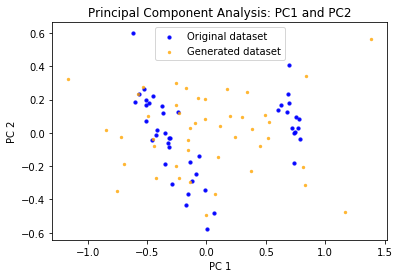

Nearest neighbors metric


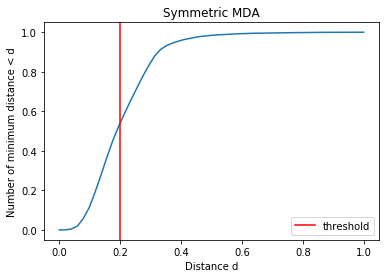

** Privacy: **0.8290886114169549

** Resemblance: **0.9359781015817982

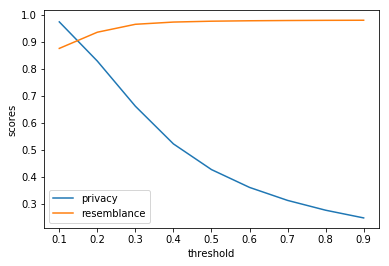

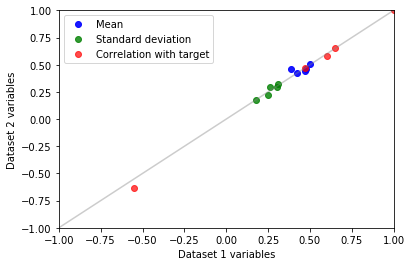

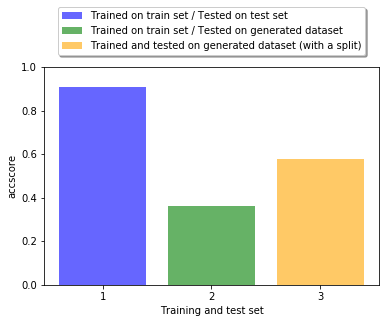

iris
kd

2 datasets detected: ready for comparison.
Explained variance ratio of the 5 components: 
 [0.75364005 0.15943482 0.06329037 0.01889279 0.00474198]
Explained variance ratio of the 5 components: 
 [0.54966847 0.18368946 0.11480231 0.09203265 0.05980712]


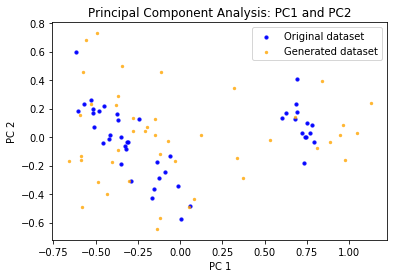

Nearest neighbors metric


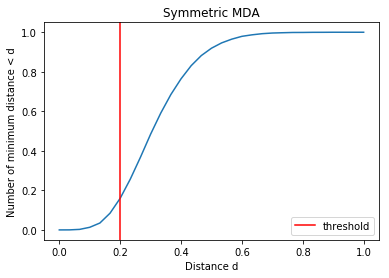

** Privacy: **0.9851472963405461

** Resemblance: **0.8429493561662019

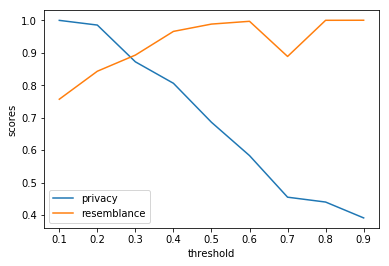

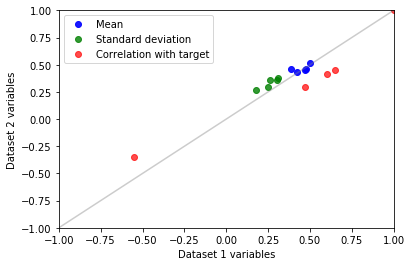

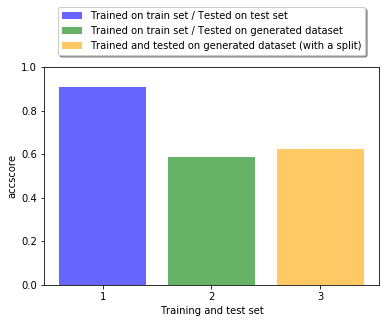

iris
rf

2 datasets detected: ready for comparison.
Explained variance ratio of the 5 components: 
 [0.75364005 0.15943482 0.06329037 0.01889279 0.00474198]
Explained variance ratio of the 5 components: 
 [0.7633659  0.18204318 0.03488332 0.01773023 0.00197737]


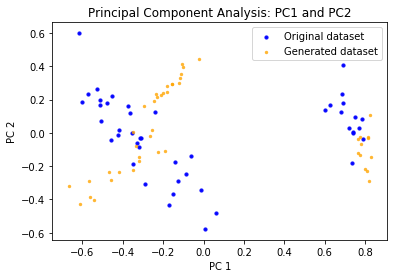

Nearest neighbors metric


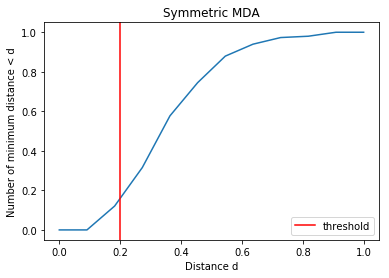

** Privacy: **0.9816961561928005

** Resemblance: **0.7713036404311571

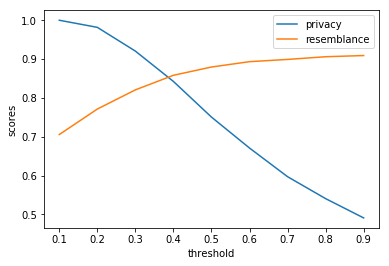

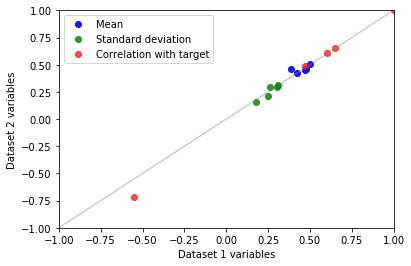

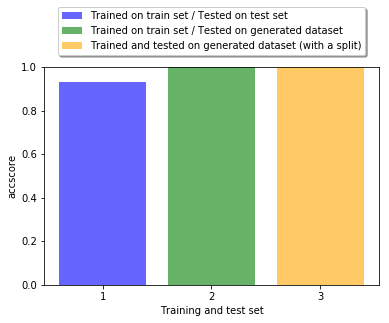

mushrooms
mg

2 datasets detected: ready for comparison.
Explained variance ratio of the 23 components: 
 [0.17282051 0.15156239 0.11394072 0.08253711 0.07236826 0.04587973
 0.04476988 0.03927652 0.03171331 0.02879375 0.02586292 0.02429041
 0.02174489 0.02126733 0.01842741 0.01713695 0.01665251 0.01610002
 0.01543295 0.012751   0.01012319 0.00954739 0.00700083]
Explained variance ratio of the 23 components: 
 [0.17672742 0.15475951 0.11918268 0.08285707 0.06263682 0.04650792
 0.04317353 0.03671513 0.03224438 0.02730283 0.02691412 0.02454795
 0.02250383 0.02067831 0.01887115 0.01744833 0.01689919 0.01580167
 0.01512596 0.01220741 0.01033108 0.00919177 0.00737195]


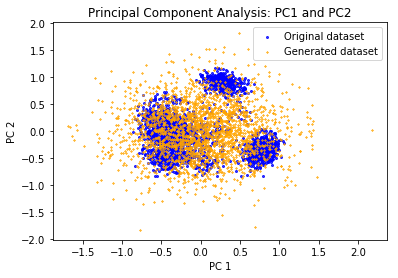

Nearest neighbors metric


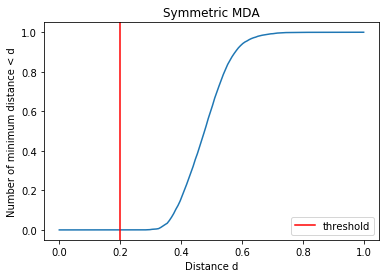

** Privacy: **1.0

** Resemblance: **0.6503246813110654

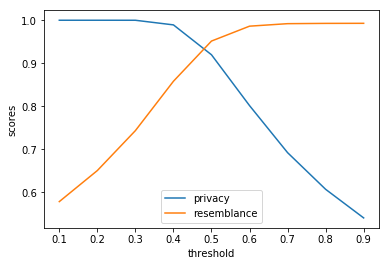

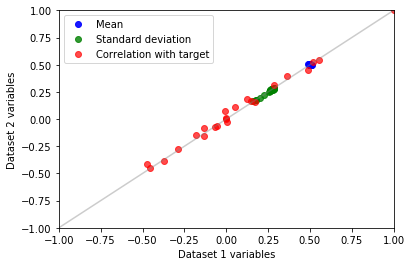

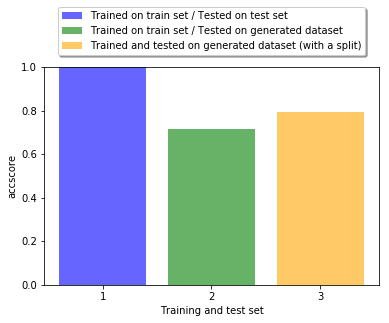

mushrooms
kd

2 datasets detected: ready for comparison.
Explained variance ratio of the 23 components: 
 [0.17282051 0.15156239 0.11394072 0.08253711 0.07236826 0.04587973
 0.04476988 0.03927652 0.03171331 0.02879375 0.02586292 0.02429041
 0.02174489 0.02126733 0.01842741 0.01713695 0.01665251 0.01610002
 0.01543295 0.012751   0.01012319 0.00954739 0.00700083]
Explained variance ratio of the 23 components: 
 [0.12458641 0.10954129 0.09318858 0.06686134 0.05785226 0.04706106
 0.04249504 0.03941658 0.03622066 0.03400998 0.03353823 0.03174762
 0.03091957 0.02905278 0.02832285 0.02794167 0.02660185 0.02618364
 0.02557336 0.02414927 0.02357682 0.02073337 0.02042577]


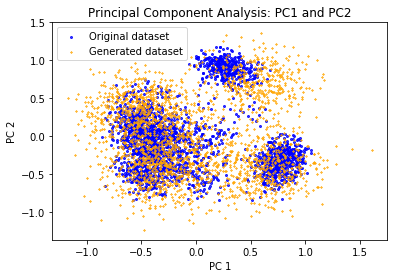

Nearest neighbors metric


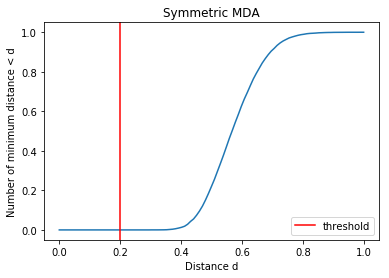

** Privacy: **1.0

** Resemblance: **0.532718725907988

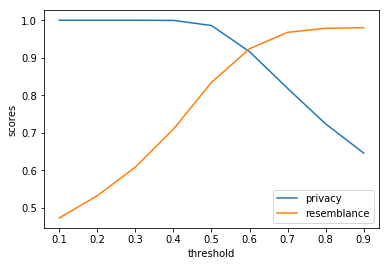

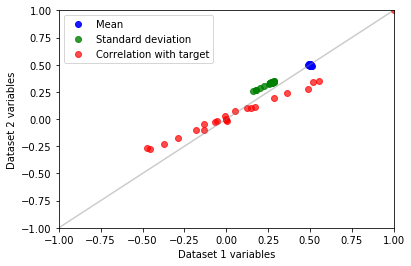

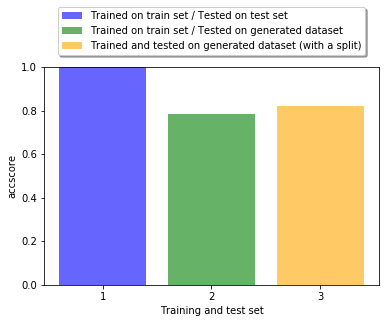

mushrooms
rf

2 datasets detected: ready for comparison.
Explained variance ratio of the 23 components: 
 [0.17282051 0.15156239 0.11394072 0.08253711 0.07236826 0.04587973
 0.04476988 0.03927652 0.03171331 0.02879375 0.02586292 0.02429041
 0.02174489 0.02126733 0.01842741 0.01713695 0.01665251 0.01610002
 0.01543295 0.012751   0.01012319 0.00954739 0.00700083]
Explained variance ratio of the 23 components: 
 [0.21160604 0.18179911 0.14148308 0.095403   0.0640828  0.03954338
 0.03705822 0.03065808 0.02490854 0.02198501 0.02091106 0.01751432
 0.01726082 0.01362568 0.01207104 0.01113306 0.01071315 0.01016089
 0.00969087 0.00877585 0.00737697 0.00649794 0.00574109]


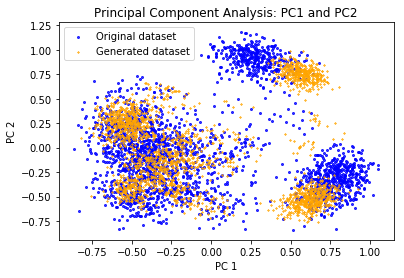

Nearest neighbors metric


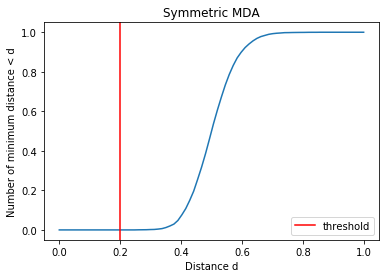

** Privacy: **1.0

** Resemblance: **0.6205673404522352

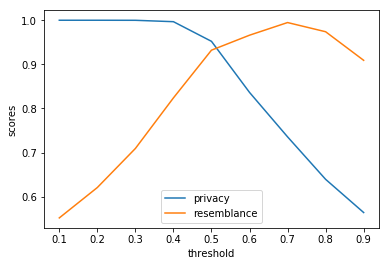

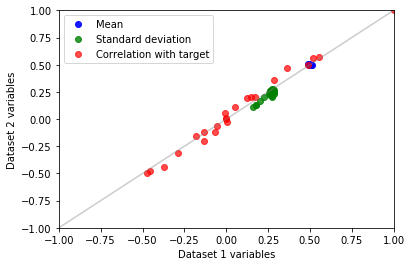

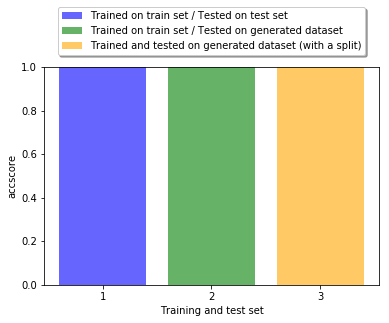

In [145]:
fig_path = '/home/adrien/Images/systematic_study/'

# Loop on datasets
for i, dataset in enumerate(datasets):
    
    # Loop on generative models
    for generator in generators:

        # Intro
        print(dataset)
        print(generator)
        print()
        
        label = labels[i]
        scoring = scorings[i]

        # A) Datasets
        # 1) Train original dataset
        train = AutoML(data_path + dataset, dataset + '_train_sdv')
        train_data = train.get_data()
        #train_y = train_data[label]
        # class, need decoded dataset
        train_cl = pd.read_csv(data_path + dataset + '/' + dataset +'_train_sdv_normal.csv')
        train_y = label_encode(train_cl[label])
        
        # 2) Test original dataset
        test = AutoML(data_path + dataset, dataset + '_test_sdv')
        test_data = test.get_data()
        #test_y = test_data[label]
        # class, need decoded dataset
        test_cl = pd.read_csv(data_path + dataset + '/' + dataset +'_test_sdv_normal.csv')
        test_y = label_encode(test_cl[label])
        
        # 3) Generated dataset
        gen = AutoML(data_path + dataset, dataset +'_'+ generator)
        gen_data = gen.get_data()
        #gen_y = gen_data[label] # should not be needed
        # class, need decoded dataset
        gen_cl = pd.read_csv(data_path + dataset + '/' + dataset +'_'+ generator + '_normal.csv')
        
        # NaN values appeared during decoding 
        # We want to drop NaN in the decoded y and then report the new index to gen_X
        # To be able to train and test a classifier on the generated data
        y = gen_cl[label].dropna()
        idx = y.index
        gen_y = label_encode(y)
        ##############################

        # B) Metrics
        # 1) Plots
        comparator = Comparator(test, gen)
        
        size = 1 # PCA plot points size
        if dataset in ['iris', 'boston']: # For small datasets ~ train_X.shape[0] < 1000
            size = 5
        
        comparator.show_pca(save=fig_path+dataset+'_'+generator+'_pca.png', label1='Original dataset', label2='Generated dataset', size=size)
        #comparator.show_lda(label)
        comparator.show_mda(save=fig_path+dataset+'_'+generator+'_mda.png')
        comparator.show_mda_threshold(save=fig_path+dataset+'_'+generator+'_threshold.png')
        comparator.compare_marginals(metric='all', target=label, save=fig_path+dataset+'_'+generator+'_marginals.png')
        
        # 2) Tasks scores
        scores = []
        
        # Drop label
        train_X = train_data.drop([label], axis=1)
        test_X = test_data.drop([label], axis=1)
        gen_X = gen_data.drop([label], axis=1).loc[idx]
        
        # train / test
        scores.append(task_score(train_X, train_y, test_X, test_y, scoring=scoring))
        
        # train / gen
        scores.append(task_score(train_X, train_y, gen_X, gen_y, scoring=scoring))
        
        # gen / gen
        gen_X_train, gen_X_test, gen_y_train, gen_y_test = train_test_split(gen_X, gen_y, test_size=0.3)
        scores.append(task_score(gen_X_train, gen_y_train, gen_X_test, gen_y_test, scoring=scoring))
        
        x = [1, 2, 3]
        
        legends = {1:('Trained on train set / Tested on test set','b'), 
              2:('Trained on train set / Tested on generated dataset','g'), 
              3:('Trained and tested on generated dataset (with a split)','orange')}

        ax1 = plt.subplot(111)

        for j in range(len(x)):
            ax1.bar(x[j], scores[j], width=0.8, bottom=0.0, align='center', color=legends[x[j]][1], alpha=0.6, label=legends[x[j]][0])
        
        ax1.set_xticks(x)
        ax1.set_xticklabels([i for i in x])

        ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
                  ncol=1, fancybox=True, shadow=True)

        plt.xlabel('Training and test set')
        plt.ylabel(scoring + 'score')
        plt.ylim(0, 1) # same scale for every plots
        
        #plt.savefig(fig_path+dataset+'_'+generator+'_score.png') # out of figure bounds
        plt.show()